In [1]:
from models_train.IQAmodel import IQAModel
import os
import numpy as np
import random
import torch
from argparse import ArgumentParser
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import resize, to_tensor, normalize
from PIL import Image
import h5py
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
%set_env CUDA_VISIBLE_DEVICES=0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = IQAModel(
                'Linearity', 
                arch="resnet101", 
                pool='avg', 
                use_bn_end=False, 
                P6=1, 
                P7=1,
                cayley_pool=True
                ).to(device)  #

server_mnt = "~/mnt/dione/28i_mel"
destination_path = os.path.expanduser(server_mnt)
path = os.path.join(destination_path, "activation=relu-Linearity-resnet101-bs=8-loss=norm-in-norm-p=1.0-q=2.0-detach-False-KonIQ-10k-res=True-498x664-clp=True")
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model'])
k = checkpoint['k']
b = checkpoint['b']
_ = model.eval()

env: CUDA_VISIBLE_DEVICES=0


/mnt/ssd2/28i_mel/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/ssd2/28i_mel/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linearity(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(6

In [5]:
%set_env CUDA_VISIBLE_DEVICES=0
from iterative import attack_callback
iter_dir = list(Path('NIPS_test').iterdir())
l_conv1 = []
l_conv2 = []
l_cayley = []
# print(list(iter_dir))
for name in tqdm(iter_dir, total=len(iter_dir)):
    # print(name)
    im = Image.open(name).convert('RGB')  #
    im = resize(im, (498, 664)) #
    im = to_tensor(im).to(device)
    im = im.unsqueeze(0)
    # pert_im = attack_callback(im, model=model, attack_type='PGD',eps=1.0, iters=1, delta=6/255, k=k, b=b, device=device)

    # x_in = pert_im
    x_in = im
    # print(x_in.shape)

    for i, layer in enumerate(model.features):
        x = layer(x_in)
        if i==6:
            lips_const = torch.norm(x)/torch.norm(x_in)
            l_conv1.append(lips_const.item())
            x_in = x
            x = model.cayley_block6(x_in)
            print(model.cayley_block6.children())
            break
            lips_const = torch.norm(x)/torch.norm(x_in)
            l_cayley.append(lips_const.item())
        if i==7:
            lips_const = torch.norm(x)/torch.norm(x_in)
            l_conv2.append(lips_const.item())
        x_in = x

env: CUDA_VISIBLE_DEVICES=0


  0%|          | 0/1000 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 

: 

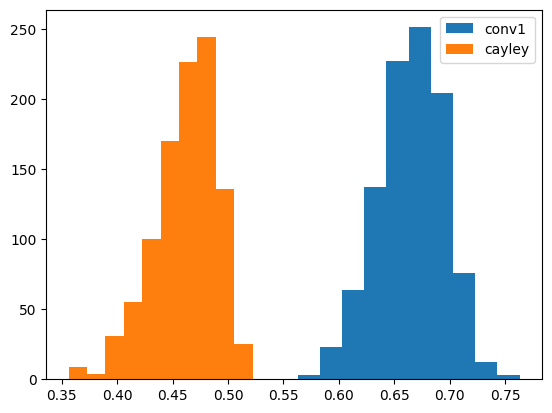

In [15]:
plt.hist(l_conv1, label='conv1')
# plt.hist(l_conv2, label='conv2')
plt.hist(l_cayley, label='cayley')
plt.legend()
plt.show()

In [17]:
%set_env CUDA_VISIBLE_DEVICES=0
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
model = IQAModel(
                'Linearity', 
                arch="resnet101", 
                pool='avg', 
                use_bn_end=False, 
                P6=1, 
                P7=1,
                cayley_pool=False
                ).to(device)  #

server_mnt = "~/mnt/dione/28i_mel"
destination_path = os.path.expanduser(server_mnt)
path = os.path.join(destination_path, "activation=relu-Linearity-resnet101-bs=8-loss=norm-in-norm-p=1.0-q=2.0-detach-False-KonIQ-10k-res=True-498x664")
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model'])
k = checkpoint['k']
b = checkpoint['b']
model.eval()

env: CUDA_VISIBLE_DEVICES=3


/mnt/ssd2/28i_mel/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/ssd2/28i_mel/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linearity(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(6

In [8]:
%set_env CUDA_VISIBLE_DEVICES=0
iter_dir = list(Path('NIPS_test').iterdir())
l_conv1 = []
l_conv2 = []
l_cayley_in = []
l_cayley_out = []
# print(list(iter_dir))
for name in tqdm(iter_dir, total=len(iter_dir)):
    # print(name)
    im = Image.open(name).convert('RGB')  #
    im = resize(im, (498, 664)) #
    im = to_tensor(im).to(device)
    im = normalize(im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    x_in = im.unsqueeze(0)
    # print(x_in.shape)

    for i, layer in enumerate(model.features):
        x = layer(x_in)
        if i==6:
            lips_const = torch.norm(x)/torch.norm(x_in)
            l_conv1.append(lips_const.item())
            x_in = x
            for cayley_layer in model.cayley_block6.children():
                x = cayley_layer(x_in)
                l_cayley_in.append(torch.norm(x)/torch.norm(x_in))
                # x_in = x
                # x = cayley_layer(x_in)
                # l_cayley_out.append(torch.norm(x)/torch.norm(x_in))
            # lips_const = torch.norm(x)/torch.norm(x_in)
            # l_cayley.append(lips_const.item())
        if i==7:
            lips_const = torch.norm(x)/torch.norm(x_in)
            l_conv2.append(lips_const.item())
        x_in = x
# plt.hist(l_conv1, label='conv1')
# plt.hist(l_conv2, label='conv2')
# plt.hist(l_cayley, label='cayley')

env: CUDA_VISIBLE_DEVICES=2


  0%|          | 0/1000 [00:00<?, ?it/s]


RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

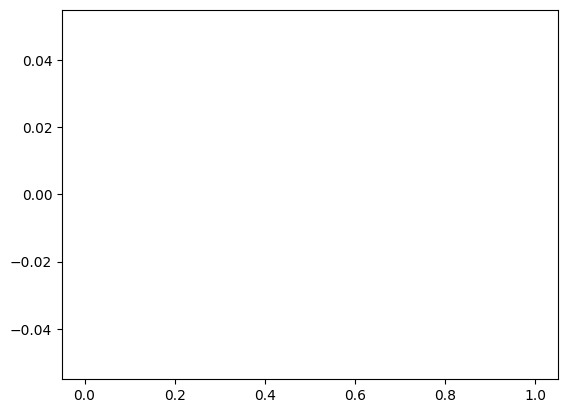

In [5]:
plt.hist(l_conv1, label='conv1')
plt.hist(l_conv2, label='conv2')